In [1]:
import pytorch_lightning as pl
from argparse import ArgumentParser
from uuid import uuid4
import torch as ch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from os import path

import numpy as np
import torch as ch
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset
import scipy.stats as stats



In [2]:
direct = '/Users/work/Documents/GitHub/mlgenomics/data_preprocessing/Wang_2018_all_2D_3D_processed_new_0_1_leftout.npz'

content = np.load(direct)['arr_0']

TEST_CELLS = 3000
VAL_CELLS = 300

# Extract the labels as the last columns
data = ch.from_numpy(content[:, :-4]).float()
coordinates = ch.from_numpy(content[:, -4:-1]).float()
dataindex = ch.from_numpy(content[:,-1]).float() 

full_dataset = TensorDataset(data, coordinates, dataindex)

num_samples = len(full_dataset)

# We want to always left out the same data to make sure it never
# leaks into our models/experiments
test_generator = ch.Generator().manual_seed(42)
# For validation we want to be able to sample different sets to do
# cross validation for example

rest, test_dataset= random_split(full_dataset, # each contains per cell: expression, coordinates, dataID
                                  [num_samples - TEST_CELLS, TEST_CELLS],
                                  generator=test_generator)

In [3]:
test_dataset

In [13]:
# evaluate on the test dataset
PATH = '/Users/work/Documents/GitHub/mlgenomics/djuna_models/lightning_logs/version_1_Wang_2018_all_2D_3D_processed_new_0_1_leftout/checkpoints/epoch=392-v0.ckpt'
new_model_unseen = SimpleFNN.load_from_checkpoint(checkpoint_path=PATH)
new_model_unseen.eval()

"lr": 0.001


SimpleFNN(
  (layers): Sequential(
    (0): Linear(in_features=1030, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [15]:
out = []
index = []
label = []
feature = []
for features, labels, dataset_idx in (iter(DataLoader(test_dataset))):
    label.append(labels.detach().numpy())
    index.append(dataset_idx.detach().numpy())
    feature.append(features.detach().numpy())
    out.append((new_model_unseen(features, dataset_idx)).detach().numpy())


In [16]:
yhat = np.concatenate(out)
idx = np.concatenate(index)
label = np.concatenate(label)
features = np.concatenate(feature)

In [17]:
yhat_data0 = yhat[np.array(np.where(idx==10)).flatten(),:]
labels_data0 = label[np.array(np.where(idx==10)).flatten(),:]
features_data0 = features[np.array(np.where(idx==10)).flatten(),:]

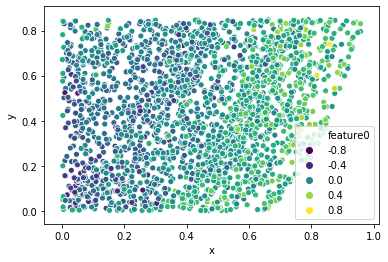

In [21]:
plot_genes(labels_data0, yhat_data0, 'viridis', 0)

[(0, 1)]

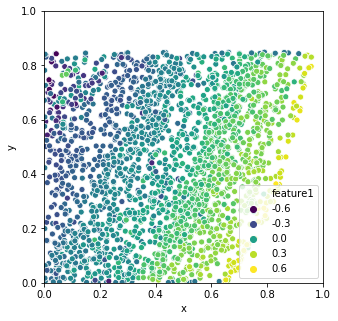

In [29]:
plt.figure(figsize=(5,5))

g = plot_genes(labels_data0, yhat_data0, 'viridis', 1)
#plt.legend([],[], frameon=False)
g.set(xlim=(0, 1))
g.set(ylim=(0, 1))

In [36]:
features_data0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

[(0, 1)]

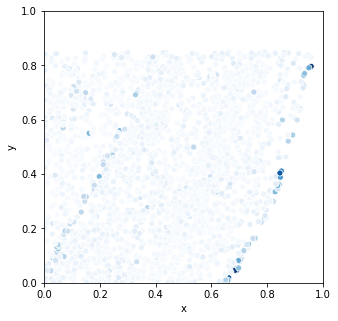

In [45]:
plt.figure(figsize=(5,5))
plt.legend([],[], frameon=False)
g.set(xlim=(0, 1))
g.set(ylim=(0, 1))
g = plot_genes(labels_data0, features_data0, 'Blues', np.where(all_genes=='Ctgf')[0][0])
plt.legend([],[], frameon=False)
g.set(xlim=(0, 1))
g.set(ylim=(0, 1))



In [250]:
genes = ['Cux2', 'Pcp4', 'Plcxd2']
df = pd.DataFrame(labels_data0)
for i in range(3):

    gene = features_data0[:,np.where(all_genes==genes[i])[0][0]] #Cux2, PCP4
    layer = ((gene-np.mean(gene))/np.std(gene))>2
    x = layer * 1
    x.astype('uint8')
    df = pd.concat([df,pd.DataFrame(x)], axis = 1)
    
df.columns = ['x', 'y','z','Cux2', 'Pcp4', 'Plcxd2']

In [251]:
layer = list()
for i in range(df.shape[0]):
    if df.loc[i,'Cux2'] == 1:
        layer.append('layer 2/3')
    elif df.loc[i,'Pcp4'] ==1 :
        layer.append('layer 5/6')        
   # elif df.loc[i,'Plcxd2'] == 1:
    #    layer.append('layer 5')  
    else:
        layer.append('other ')  

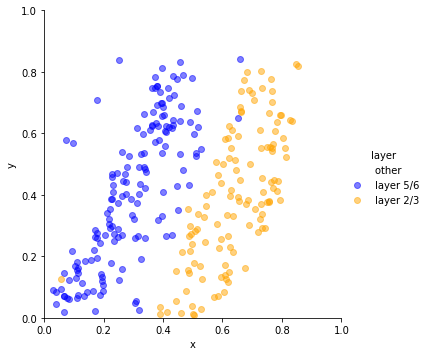

In [252]:
all_d = pd.concat([df,pd.DataFrame(layer)], axis = 1)
all_d.columns = ['x', 'y','z','Cux2', 'Pcp4', 'Plcxd2', 'layer']

g = sns.lmplot(data = all_d, x = 'x', y = 'y', hue = 'layer',  fit_reg=False, scatter_kws = {'alpha':0.5}, palette = ['white', 'blue', 'orange', 'green'])
#plt.legend([],[], frameon=False)
g.set(xlim=(0, 1))
g.set(ylim=(0, 1))




In [253]:
new = pd.concat([all_d,pd.DataFrame(yhat_data0)], axis = 1)

In [254]:
df_wide=new.pivot(columns='layer',values=0)

Text(0.5, 0, 'feature 1')

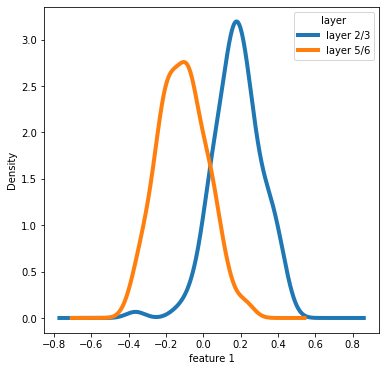

In [255]:
df_wide = df_wide[['layer 2/3','layer 5/6']]
df_wide.plot.density(figsize=(6,6),linewidth=4)
plt.xlabel('feature 1')

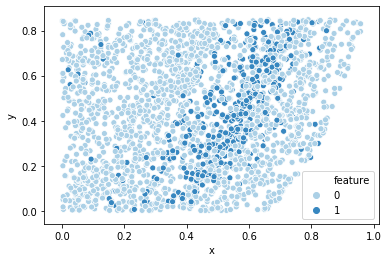

In [108]:

all_d = pd.concat([pd.DataFrame(labels_data0),pd.DataFrame(x)], axis = 1)
all_d.columns = ['x', 'y','z','feature']
g = sns.scatterplot(data = all_d, x = 'x', y = 'y', hue = 'feature',palette= 'Blues')

In [106]:
np.where(all_genes=='PCP4')

(array([], dtype=int64),)

In [176]:
# use the unseen dataset 

direct_leftout = '/Users/work/Documents/GitHub/mlgenomics/data_preprocessing/Wang_2018_all_2D_3D_processed_new.npz'
content_leftout = np.load(direct_leftout)['arr_0']
unseen_0 = content_leftout[content_leftout[:,-1]==1,]


In [177]:
data_unseen = ch.from_numpy(unseen_0[:, :-4]).float()
coordinates_unseen = ch.from_numpy(unseen_0[:, -4:-1]).float()
dataindex_unseen = ch.from_numpy(unseen_0[:,-1]).float() 

full_dataset_unseen  = TensorDataset(data_unseen , coordinates_unseen , dataindex_unseen )

In [178]:
out = []
index = []
label = []
feature = []
for features, labels, dataset_idx in (iter(DataLoader(full_dataset_unseen))):
    label.append(labels.detach().numpy())
    index.append(dataset_idx.detach().numpy())
    feature.append(features.detach().numpy())
    out.append((new_model_unseen(features, dataset_idx)).detach().numpy())


In [179]:
yhat = np.concatenate(out)
idx = np.concatenate(index)
label = np.concatenate(label)
features = np.concatenate(feature)

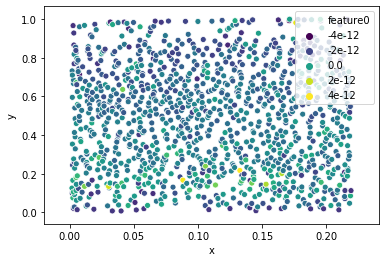

In [183]:
plot_genes(label, yhat, 'viridis', 0)

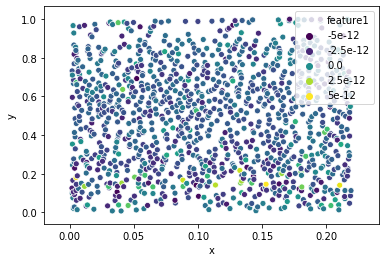

In [184]:
plot_genes(label, yhat, 'viridis', 1)

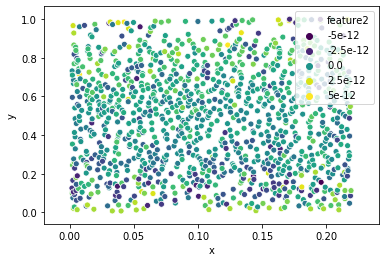

In [185]:
plot_genes(label, yhat, 'viridis', 2)

In [186]:
# get labels for this dataset
dirs = os.listdir('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')

data_dir = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[1],'class_labels.csv')
celltype_labels = pd.read_csv(data_dir)

In [187]:
labels_subsetted = label[np.array(celltype_labels[['CellID']]).flatten(),:]
celltype_labels = np.array(celltype_labels[['ClusterName']]).flatten()

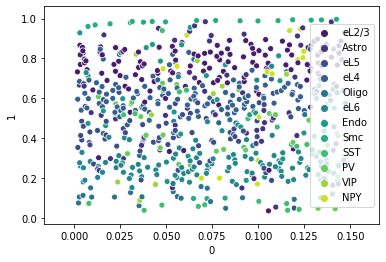

In [188]:
sns.scatterplot(data = pd.DataFrame(labels_subsetted), x = 0, y = 1, hue =celltype_labels,palette= 'viridis')


In [192]:
include = set(('Astro-1',
 'Astro-2',
 'Endo',
 'Micro',
 'Oligo',
 'Astro', 'Smc', 'Astro'))


In [190]:
subsetted_labels = [None if item not in include else item for item in celltype_labels]

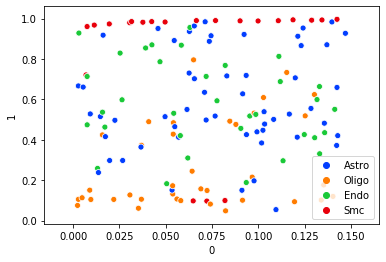

In [196]:
sns.scatterplot(data = pd.DataFrame(labels_subsetted), x = 0, y = 1, hue =subsetted_labels,palette=sns.color_palette("bright", 4))


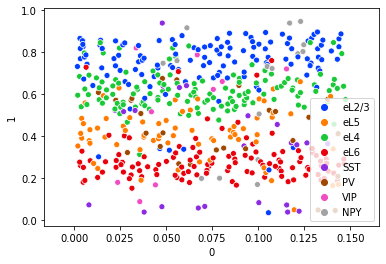

In [198]:
subsetted_labels_neurons = [None if item in include else item for item in celltype_labels]
sns.scatterplot(data = pd.DataFrame(labels_subsetted), x = 0, y = 1, hue =subsetted_labels_neurons,palette=sns.color_palette("bright", 8))


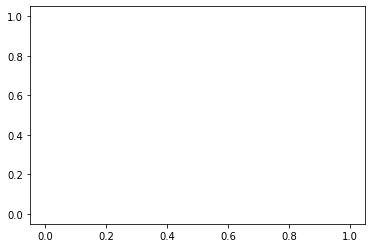

In [199]:
micro = np.array(np.where(celltype_labels=='Micro')).flatten()
plot_genes(label[micro,:], yhat[micro,:], 'viridis', 0)

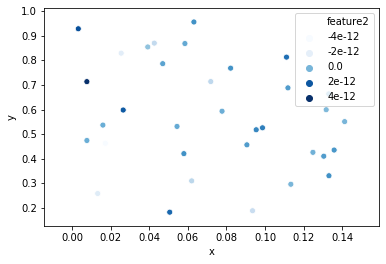

In [213]:
endo = np.array(np.where(celltype_labels=='Endo')).flatten()
plot_genes(label[endo,:], yhat[endo,:], 'Blues', 2)

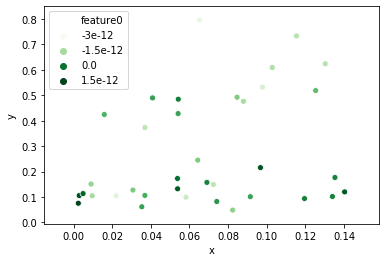

In [217]:
oligo = np.array(np.where(celltype_labels=='Oligo')).flatten()
plot_genes(label[oligo,:], yhat[oligo,:], 'Greens', 0)

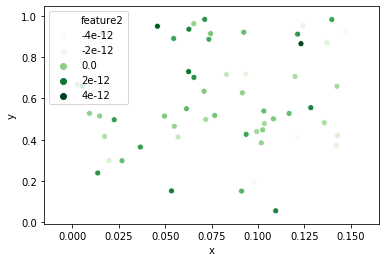

In [221]:
oligo = np.array(np.where(celltype_labels=='Astro')).flatten()
plot_genes(label[oligo,:], yhat[oligo,:], 'Greens', 2)

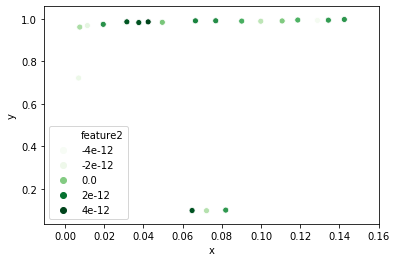

In [208]:
oligo = np.array(np.where(celltype_labels=='Smc')).flatten()
plot_genes(label[oligo,:], yhat[oligo,:], 'Greens', 2)

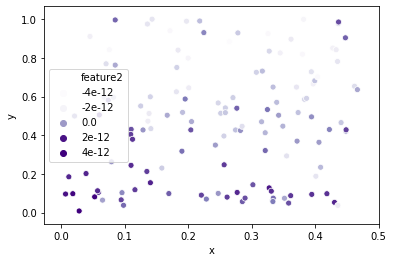

In [168]:
astro = np.array(np.where((celltype_labels=='Astro-2') | (celltype_labels=='Astro-1') )).flatten()
plot_genes(label[astro,:], yhat[astro,:], 'Purples', 2)


In [61]:
def plot_genes(labels_data0, yhat_data0, cmap, index):
  
    all_d = pd.concat([pd.DataFrame(labels_data0), pd.DataFrame(yhat_data0[:,index])], axis = 1)
    all_d.columns = ['x', 'y','z','feature'+str(index)]

    
    g = sns.scatterplot(data = all_d, x = 'x', y = 'y', hue = 'feature'+str(index),palette= cmap)
    
    return g

def plot_genes2(labels_data0, yhat_data0, cmap, index):
  
    all_d = pd.concat([pd.DataFrame(labels_data0),index], axis = 1)
    all_d.columns = ['x', 'y','z','feature']

    
    g = sns.scatterplot(data = all_d, x = 'x', y = 'y', hue = 'feature',palette= cmap)
    
    return g

In [11]:
import os
import torch
from argparse import ArgumentParser
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split
import numpy.ma as ma

# modify the code to run on multiple independent inputs 
# the 3D input, and all the 2D inputs, but then compute the loss 

# how do we train the network on multiple independent datasets?: Alternate between the different datasets

class SimpleFNN(pl.LightningModule):

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--lr', type=float, default=1e-3)
        return parser

    def __init__(self, lr, *args, **kwargs): # constructing the neural net
        super().__init__()
        self.save_hyperparameters()
        print(self.hparams)
        size = 128
        num_layers = 5
        layers = []
        layers.append(torch.nn.Linear(1030, size)) # applies linear transformation to incomping data
        layers.append(torch.nn.BatchNorm1d(size, affine=False)) # application of batch normalization

        for _ in range(num_layers - 1):
            layers.append(torch.nn.ReLU(inplace=True))
            layers.append(torch.nn.Linear(size, size))
            layers.append(torch.nn.BatchNorm1d(size, affine=False))
            
        layers.append(torch.nn.Linear(size, 3)) # we care about the last layer as the model's projection into n-d space
      
        # add a final layer that implements data-specific scaling factor
        self.layers = torch.nn.Sequential(*layers)

        self.register_parameter('scale_weights',torch.nn.Parameter(torch.ones(11)))  # initiate empty torch
        

    def forward(self, x, ID): # accept tensor of input data and return tensor of output data
        
        q = x.view(x.size(0), -1)
       
        q = self.layers(q) # run the model on the data

        # multiply each col in q by this
        indexed_weights = torch.index_select(self.scale_weights, 0, ID.long())
        return indexed_weights[:,None]*q

    def compute_matrix(self, x, ID): # compute pairwise distances for input matrix 
        x = x[:, None, :] - x[None, :, :]
        x = (x ** 2).mean(2)

        mask = ID[:, None] - ID[None, :]
        mask[abs(mask)>0] = 1
        
        return x * (mask)

    def compute_loss(self, x, y, y_hat, ID):
        true_matrix = self.compute_matrix(y, ID)
        pred_matrix = self.compute_matrix(y_hat, ID)

        loss = (true_matrix - pred_matrix).abs().mean() # compute average difference in pairwise distances between true and predicted --> this is the loss

        return loss

    def configure_optimizers(self):
        print(self.hparams)
        optimizer = torch.optim.Adam(self.parameters(), lr=(self.hparams.lr),
                                     weight_decay=1e-2)
        scheduler = StepLR(optimizer, 100, gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx): # batch is the output of the dataloader
        x, y, ID = batch 
    
        y_hat = self(x, ID) # get model output (calls forward)

        loss = self.compute_loss(x, y, y_hat, ID) # compute loss between actual and predicted

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, ID = batch
        y_hat = self(x, ID) # compute output on validation set
        loss = self.compute_loss(x, y, y_hat, ID) # get loss 
        self.log('validation_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)# log and return the loss
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x, ID)
        loss = self.compute_loss(x, y, y_hat, ID)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss


In [9]:
#  get union of all gene names (across 3D and 2D datasets)
genenames_3D = pd.read_csv('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/sequentially_encoded_Wang_et_al_2018/gene_names.csv', header = 0)

dirs = os.listdir('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')

ct = []

for i in range(len(dirs)):

    data_dir1 = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[i])

    ct.append(load_data(data_dir1, prefix=""))

genenames = []
for i in range(len(dirs)):
    genenames.append(ct[i].columns)

all_genes = np.unique(np.concatenate((np.unique(np.concatenate(genenames)),(np.array(genenames_3D).flatten()))))


In [8]:
def load_data(data_dir, prefix="Cell"):
        #expr = pd.read_csv(os.path.join(data_dir, "data_table.csv"), index_col=0)
    expr = pd.read_csv(os.path.join(data_dir, "cell_barcode_count.csv"), header=None)
    gene_names = pd.read_csv(os.path.join(data_dir, "cell_barcode_names.csv"),header=None)
    rownames = [i for i in range(expr.shape[0])]
    names = gene_names[2]
    names.name = "Gene"
    return pd.DataFrame(data=expr.values, columns=names, index=rownames)


201